In [13]:
import numpy as np
from numba import njit
from typing import Tuple
import matplotlib.pyplot as plt


def convert_params(mu: float, eta: float) -> Tuple[float, float]:
    """
    Convert the mu-eta parametrization to alpha-beta
    """
    alpha = mu / (eta * (1 - mu))
    beta = 1./eta

    return alpha, beta


def heuritic_params(mu: float) -> Tuple[float, float]:
    p = (1 - mu) / mu
    sigma = 1 - mu

    a = (p - sigma ** 2) / sigma ** 2
    b = p * a

    return 2 * a, 2 * b


@njit
def get_beta_vector(T: int,
                    α: float,
                    β: float) -> np.ndarray:
    discount = np.zeros((1, T), dtype=np.float32)

    current_discount = 1
    for t in range(T):
        discount[0, t] = current_discount
        current_discount *= (α + t) / (α + β + t)

    return discount


@njit
def beta_gae(rewards: np.ndarray,  # [T, N]
             values: np.ndarray,  # [T, N]
             last_values: np.ndarray,  # [1, N]
             dones: np.ndarray,  # [T, N], actually next_dones (whether previous step was terminal)
             final_dones: np.ndarray,  # [1, ]
             α: float = 99.,
             β: float = 1.,
             λ: float = 0.95):
    T = rewards.shape[0]
    N = rewards.shape[1]  # Number of envs

    advantages = np.zeros((T, N), dtype=np.float32)

    final_dones = final_dones.reshape((1, N))
    last_values = last_values.reshape((1, N))
    next_non_terminal = 1 - np.concatenate((dones, final_dones))[1:]
    next_values = np.concatenate((values, last_values))[1:]

    Γ = get_beta_vector(T + 1, α, β)
    lambdas = np.array([[λ ** l for l in range(T)]], dtype=np.float32)

    #     γ = α / (α + β)
    #     Γ = np.array([[γ**l for l in range(T+1)]])

    for n in range(N):
        # Done preprocessing step
        steps_until_eoe = np.zeros((T,), dtype=np.int32)
        is_final = np.zeros((T,), dtype=np.int32)
        counter = 0
        final = 1
        done = False
        factor = None

        for i, d in list(enumerate(dones[:, n]))[::-1]:
            if done:
                counter = 0
                done = False
                final = 0
            steps_until_eoe[i] = counter
            is_final[i] = final
            counter += 1
            done = d

        for i in range(T):
            steps_left = steps_until_eoe[i]

            old_value = -values[i, n]
            future_rewards = (lambdas[:, :steps_left + 1] * Γ[:, :steps_left + 1]) @ rewards[i:i + steps_left + 1,
                                                                                     n:n + 1]

            if is_final[i]:
                steps_left += 1

                # Fix to properly handle the very last value of an episode
                if factor is None:
                    factor = np.array([[1 - λ for i in range(steps_left)]], dtype=np.float32).T
                    factor[-1] = 1.
                else:
                    factor = factor[1:]

                future_values = (lambdas[:, :steps_left] * Γ[:, 1:steps_left + 1]) @ (
                        next_values[i:i + steps_left, n:n + 1] * next_non_terminal[i:i + steps_left, n:n + 1] * factor[
                                                                                                                -steps_left:])

            else:
                future_values = np.float32(1. - λ) * (lambdas[:, :steps_left] * Γ[:, 1:steps_left + 1]) @ (
                        next_values[i:i + steps_left, n:n + 1] * next_non_terminal[i:i + steps_left, n:n + 1])

            total = old_value + future_rewards + future_values
            advantages[i, n] = total[0, 0]

    returns = advantages + values

    return returns, advantages



In [18]:
rewards = np.zeros((100, 1), dtype=np.float32)
rewards[-1] = 1
values = np.zeros((100, 1), dtype=np.float32)
last_values = np.zeros((1, 1), dtype=np.float32)
dones = np.array([False for _ in range(100)]).reshape((100, 1))
final_dones = np.array([False])

In [25]:
returns, advantages = beta_gae(rewards, values, last_values, dones, final_dones, 99*2, 1*2, 0.95)

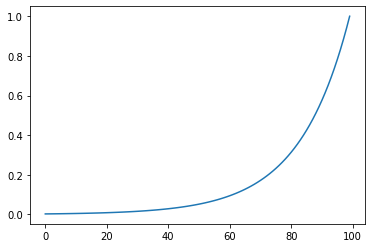

In [26]:
plt.plot(returns)

In [27]:
advantages.ravel()

array([0.00277449, 0.00294024, 0.00311598, 0.00330229, 0.00349982,
       0.00370925, 0.00393131, 0.00416676, 0.00441642, 0.00468115,
       0.00496186, 0.00525954, 0.00557521, 0.00590997, 0.00626498,
       0.00664149, 0.0070408 , 0.00746431, 0.00791349, 0.00838992,
       0.00889526, 0.00943128, 0.00999986, 0.01060301, 0.01124283,
       0.01192157, 0.01264163, 0.01340555, 0.01421603, 0.01507591,
       0.01598825, 0.01695628, 0.01798342, 0.01907333, 0.02022986,
       0.02145714, 0.02275955, 0.02414171, 0.02560855, 0.02716534,
       0.02881762, 0.03057132, 0.03243274, 0.03440854, 0.03650584,
       0.03873217, 0.04109558, 0.04360457, 0.04626822, 0.04909616,
       0.05209863, 0.05528652, 0.05867141, 0.0622656 , 0.06608219,
       0.07013507, 0.07443906, 0.07900988, 0.08386426, 0.08902001,
       0.09449603, 0.10031247, 0.10649073, 0.11305358, 0.12002526,
       0.12743154, 0.13529985, 0.14365932, 0.15254104, 0.16197804,
       0.1720054 , 0.18266061, 0.19398344, 0.20601624, 0.21880